In [32]:
import os
import pandas as pd
import cv2
import numpy as np
import math
import xml.dom.minidom
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from PIL import Image
from glob import glob

## Functions 

In [33]:
# Create directories

def create_dir(dirname):
    
    try:
        os.mkdir(dirname)
    except OSError:
        print ("Creation of the directory %s failed" % dirname)
    else:
        print ("Successfully created the directory %s " % dirname)

## Create directories and path to dhSegment output

In [37]:
# Directories and create folders
root_dir = "../Outputs/MM_seg/"

create_dir(root_dir)

# Choose the name of the folder to store all the results and resulting mark database
folder = "753_1588848"
reg_dir = "../Outputs/MM_seg/" + folder + "/model_output_regions/"
DB_dir = "../Outputs/MM_seg/" + folder + "/DB/"
xml_dir = "processed_marks/page_xml/*"
xmls = glob(xml_dir)

create_dir(DB_dir)
create_dir(reg_dir)

Creation of the directory ../Outputs/MM_seg/ failed
Successfully created the directory ../Outputs/MM_seg/753_1588848/DB/ 
Creation of the directory ../Outputs/MM_seg/753_1588848/model_output_regions/ failed


In [38]:
# Check the files in xml directory

for page in xmls:
    print(page)
    
print(len(xmls))

processed_marks/page_xml/113_21_0057.xml
processed_marks/page_xml/114_7_0076.xml
processed_marks/page_xml/105_11_0076.xml
processed_marks/page_xml/105_6_0052.xml
processed_marks/page_xml/114_7_0078.xml
processed_marks/page_xml/105_6_0038.xml
processed_marks/page_xml/105_11_0105.xml
processed_marks/page_xml/105_11_0117.xml
processed_marks/page_xml/94_20_0082.xml
processed_marks/page_xml/95_32_0051.xml
processed_marks/page_xml/105_11_0077.xml
processed_marks/page_xml/114_7_0077.xml
processed_marks/page_xml/105_11_0103.xml
processed_marks/page_xml/94_20_0059.xml
processed_marks/page_xml/105_11_0099.xml
15


## Extract XML regions

In [39]:
# Extract model output data from XMLs (XML has the coordinates as x1,y1 x2,y2 x3,y3 x4,y4)
                                                               # (bl, br, tr, tl)

output = []

for page in xmls:

    data = []
    regions = []    
    doc = xml.dom.minidom.parse(page)
    
    name = doc.getElementsByTagName("Page")
    print("\nPage being analysed is " + name[0].getAttribute("imageFilename"))
    data.append(name[0].getAttribute("imageFilename")[:-4])
    
    Nodelist = doc.getElementsByTagName('Coords')
    
    for node in Nodelist:
        coords = []
        coordsTemp = node.getAttribute("points")
        coordsTemp = coordsTemp.split(' ')
        for x in coordsTemp:
            temp = x.split(',')
            coords.append((int(temp[0]),int(temp[1])))

        regions.append(coords)
        
    data.append(regions)
    output.append(data)

print("")
print(len(output))


Page being analysed is 113_21_0057.png

Page being analysed is 114_7_0076.png

Page being analysed is 105_11_0076.png

Page being analysed is 105_6_0052.jpg

Page being analysed is 114_7_0078.png

Page being analysed is 105_6_0038.jpg

Page being analysed is 105_11_0105.png

Page being analysed is 105_11_0117.png

Page being analysed is 94_20_0082.jpg

Page being analysed is 95_32_0051.jpg

Page being analysed is 105_11_0077.png

Page being analysed is 114_7_0077.png

Page being analysed is 105_11_0103.png

Page being analysed is 94_20_0059.jpg

Page being analysed is 105_11_0099.png

15


## Pixel-based heuristic, creat projection signatures and analysis


Open 113_21_0057

Cropping 113_21_0057 region 0
The size of region 0:
(259, 419)
The coordinates are: 
[(1155, 4256), (1574, 4256), (1574, 4515), (1155, 4515)]
The number of detected regions are: 3
Region 0 is 2 rows
Region 1 is 3 rows
Region 2 is 168 rows
Region 0 needs to be removed
Region 1 needs to be removed
This region contains only one mark

Cropping 113_21_0057 region 1
The size of region 1:
(167, 151)
The coordinates are: 
[(1389, 3470), (1540, 3470), (1540, 3637), (1389, 3637)]
This region contains only one mark

Open 114_7_0076

Cropping 114_7_0076 region 2
The size of region 2:
(4097, 418)
The coordinates are: 
[(4721, 1564), (5139, 1564), (5139, 5661), (4721, 5661)]
The number of detected regions are: 77
Region 0 is 5 rows
Region 1 is 11 rows
Region 2 is 131 rows
Region 3 is 4 rows
Region 4 is 2 rows
Region 5 is 1 rows
Region 6 is 114 rows
Region 7 is 1 rows
Region 8 is 1 rows
Region 9 is 1 rows
Region 10 is 124 rows
Region 11 is 10 rows
Region 12 is 109 rows
Region 13 is

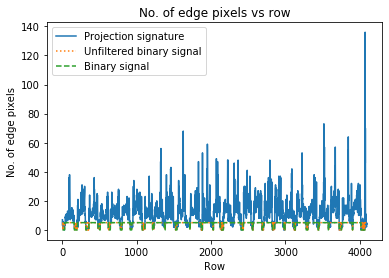

The number of detected regions are: 26
Region 0 is 131 rows
Region starts at 29
Region 1 is 114 rows
Region starts at 201
Region 2 is 124 rows
Region starts at 355
Region 3 is 109 rows
Region starts at 509
Region 4 is 134 rows
Region starts at 645
Region 5 is 109 rows
Region starts at 803
Region 6 is 140 rows
Region starts at 933
Region 7 is 104 rows
Region starts at 1110
Region 8 is 144 rows
Region starts at 1231
Region 9 is 139 rows
Region starts at 1383
Region 10 is 173 rows
Region starts at 1542
Region 11 is 150 rows
Region starts at 1718
Region 12 is 142 rows
Region starts at 1884
Region 13 is 93 rows
Region starts at 2033
Region 14 is 238 rows
Region starts at 2167
Region 15 is 120 rows
Region starts at 2435
Region 16 is 118 rows
Region starts at 2568
Region 17 is 120 rows
Region starts at 2707
Region 18 is 123 rows
Region starts at 2855
Region 19 is 123 rows
Region starts at 2995
Region 20 is 145 rows
Region starts at 3135
Region 21 is 136 rows
Region starts at 3304
Region 22 is

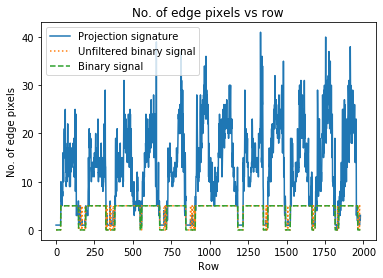

The number of detected regions are: 11
Region 0 is 116 rows
Region starts at 31
Region 1 is 132 rows
Region starts at 193
Region 2 is 165 rows
Region starts at 383
Region 3 is 117 rows
Region starts at 558
Region 4 is 125 rows
Region starts at 720
Region 5 is 276 rows
Region starts at 907
Region 6 is 132 rows
Region starts at 1218
Region 7 is 115 rows
Region starts at 1379
Region 8 is 141 rows
Region starts at 1525
Region 9 is 130 rows
Region starts at 1687
Region 10 is 124 rows
Region starts at 1840

Open 105_11_0076

Cropping 105_11_0076 region 39
The size of region 39:
(903, 427)
The coordinates are: 
[(837, 3529), (1264, 3529), (1264, 4432), (837, 4432)]
The number of detected regions are: 7
Region 0 is 156 rows
Region 1 is 1 rows
Region 2 is 123 rows
Region 3 is 124 rows
Region 4 is 131 rows
Region 5 is 5 rows
Region 6 is 273 rows
Region 1 needs to be removed
Region 5 needs to be removed


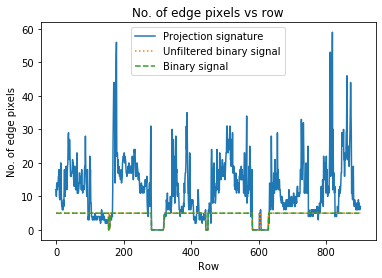

The number of detected regions are: 5
Region 0 is 156 rows
Region starts at 0
Region 1 is 123 rows
Region starts at 160
Region 2 is 124 rows
Region starts at 320
Region 3 is 131 rows
Region starts at 451
Region 4 is 273 rows
Region starts at 630

Cropping 105_11_0076 region 44
The size of region 44:
(811, 310)
The coordinates are: 
[(770, 5937), (1080, 5937), (1080, 6748), (770, 6748)]
The number of detected regions are: 7
Region 0 is 5 rows
Region 1 is 5 rows
Region 2 is 134 rows
Region 3 is 106 rows
Region 4 is 96 rows
Region 5 is 91 rows
Region 6 is 115 rows
Region 0 needs to be removed
Region 1 needs to be removed


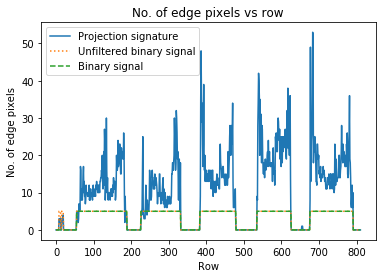

The number of detected regions are: 5
Region 0 is 134 rows
Region starts at 55
Region 1 is 106 rows
Region starts at 226
Region 2 is 96 rows
Region starts at 383
Region 3 is 91 rows
Region starts at 535
Region 4 is 115 rows
Region starts at 676

Cropping 105_11_0076 region 49
The size of region 49:
(460, 368)
The coordinates are: 
[(946, 2233), (1314, 2233), (1314, 2693), (946, 2693)]
The number of detected regions are: 3
Region 0 is 153 rows
Region 1 is 140 rows
Region 2 is 3 rows
Region 2 needs to be removed


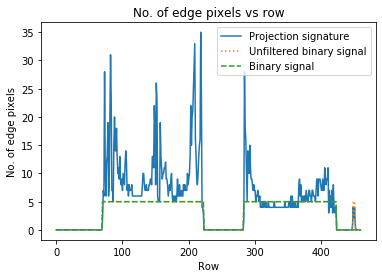

The number of detected regions are: 2
Region 0 is 153 rows
Region starts at 70
Region 1 is 140 rows
Region starts at 283

Cropping 105_11_0076 region 51
The size of region 51:
(267, 527)
The coordinates are: 
[(879, 4708), (1406, 4708), (1406, 4975), (879, 4975)]
The number of detected regions are: 2
Region 0 is 6 rows
Region 1 is 157 rows
Region 0 needs to be removed
This region contains only one mark

Cropping 105_11_0076 region 52
The size of region 52:
(251, 452)
The coordinates are: 
[(896, 7116), (1348, 7116), (1348, 7367), (896, 7367)]
The number of detected regions are: 2
Region 0 is 143 rows
Region 1 is 4 rows
Region 1 needs to be removed
This region contains only one mark

Open 105_6_0052

Cropping 105_6_0052 region 53
The size of region 53:
(277, 502)
The coordinates are: 
[(1697, 3674), (2199, 3674), (2199, 3951), (1697, 3951)]
The number of detected regions are: 2
Region 0 is 178 rows
Region 1 is 1 rows
Region 1 needs to be removed
This region contains only one mark

Cropp

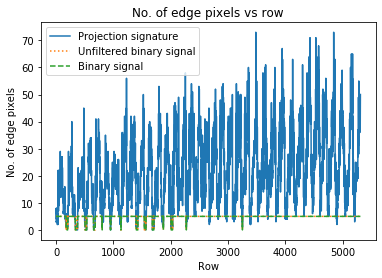

The number of detected regions are: 15
Region 0 is 177 rows
Region starts at 0
Region 1 is 133 rows
Region starts at 203
Region 2 is 129 rows
Region starts at 376
Region 3 is 118 rows
Region starts at 536
Region 4 is 121 rows
Region starts at 684
Region 5 is 141 rows
Region starts at 806
Region 6 is 176 rows
Region starts at 953
Region 7 is 265 rows
Region starts at 1135
Region 8 is 112 rows
Region starts at 1428
Region 9 is 110 rows
Region starts at 1569
Region 10 is 165 rows
Region starts at 1707
Region 11 is 134 rows
Region starts at 1873
Region 12 is 239 rows
Region starts at 2033
Region 13 is 977 rows
Region starts at 2274
Region 14 is 2058 rows
Region starts at 3252

Cropping 114_7_0078 region 70
The size of region 70:
(133, 176)
The coordinates are: 
[(1004, 6899), (1180, 6899), (1180, 7032), (1004, 7032)]
This region contains only one mark

Open 105_6_0038

Open 105_11_0105

Cropping 105_11_0105 region 71
The size of region 71:
(393, 753)
The coordinates are: 
[(1438, 2059), (2

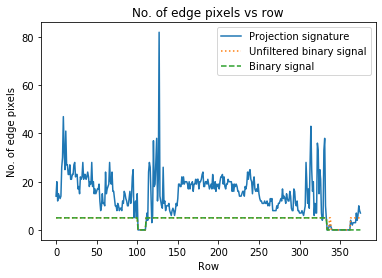

The number of detected regions are: 2
Region 0 is 101 rows
Region starts at 0
Region 1 is 223 rows
Region starts at 111

Open 105_11_0077

Cropping 105_11_0077 region 75
The size of region 75:
(401, 452)
The coordinates are: 
[(1172, 4089), (1624, 4089), (1624, 4490), (1172, 4490)]
The number of detected regions are: 3
Region 0 is 1 rows
Region 1 is 121 rows
Region 2 is 141 rows
Region 0 needs to be removed


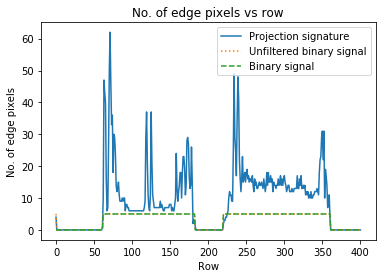

The number of detected regions are: 2
Region 0 is 121 rows
Region starts at 62
Region 1 is 141 rows
Region starts at 220

Cropping 105_11_0077 region 77
The size of region 77:
(326, 385)
The coordinates are: 
[(1272, 6472), (1657, 6472), (1657, 6798), (1272, 6798)]
The number of detected regions are: 1
Region 0 is 243 rows
This region contains only one mark

Cropping 105_11_0077 region 78
The size of region 78:
(343, 343)
The coordinates are: 
[(1105, 5209), (1448, 5209), (1448, 5552), (1105, 5552)]
The number of detected regions are: 3
Region 0 is 153 rows
Region 1 is 121 rows
Region 2 is 4 rows
Region 2 needs to be removed


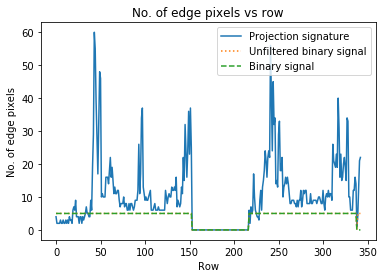

The number of detected regions are: 2
Region 0 is 153 rows
Region starts at 0
Region 1 is 121 rows
Region starts at 217

Cropping 105_11_0077 region 80
The size of region 80:
(226, 469)
The coordinates are: 
[(1289, 1923), (1758, 1923), (1758, 2149), (1289, 2149)]
This region contains only one mark

Cropping 105_11_0077 region 81
The size of region 81:
(242, 394)
The coordinates are: 
[(1255, 3186), (1649, 3186), (1649, 3428), (1255, 3428)]
This region contains only one mark

Open 114_7_0077

Cropping 114_7_0077 region 82
The size of region 82:
(4005, 427)
The coordinates are: 
[(971, 1514), (1398, 1514), (1398, 5519), (971, 5519)]
The number of detected regions are: 58
Region 0 is 3 rows
Region 1 is 1 rows
Region 2 is 8 rows
Region 3 is 131 rows
Region 4 is 1 rows
Region 5 is 1 rows
Region 6 is 114 rows
Region 7 is 121 rows
Region 8 is 1 rows
Region 9 is 110 rows
Region 10 is 5 rows
Region 11 is 150 rows
Region 12 is 107 rows
Region 13 is 1 rows
Region 14 is 127 rows
Region 15 is 3 ro

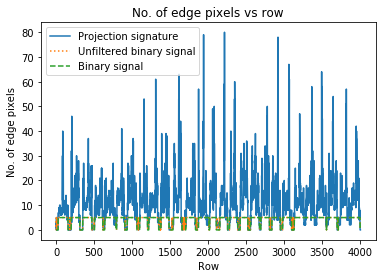

The number of detected regions are: 24
Region 0 is 131 rows
Region starts at 27
Region 1 is 114 rows
Region starts at 199
Region 2 is 121 rows
Region starts at 351
Region 3 is 110 rows
Region starts at 506
Region 4 is 150 rows
Region starts at 640
Region 5 is 107 rows
Region starts at 797
Region 6 is 127 rows
Region starts at 937
Region 7 is 104 rows
Region starts at 1100
Region 8 is 131 rows
Region starts at 1219
Region 9 is 107 rows
Region starts at 1379
Region 10 is 118 rows
Region starts at 1539
Region 11 is 128 rows
Region starts at 1707
Region 12 is 139 rows
Region starts at 1873
Region 13 is 88 rows
Region starts at 2021
Region 14 is 103 rows
Region starts at 2154
Region 15 is 108 rows
Region starts at 2282
Region 16 is 102 rows
Region starts at 2422
Region 17 is 119 rows
Region starts at 2558
Region 18 is 115 rows
Region starts at 2693
Region 19 is 112 rows
Region starts at 2839
Region 20 is 118 rows
Region starts at 2981
Region 21 is 424 rows
Region starts at 3134
Region 22 is

In [40]:
# Create the analysis images and count the pixels (BW not colour)
# metric used for calculation of the series
# db used to analyse the individual pages
metrics = []
fnames = []
mark_ids = []
co = []
m_count = 0

for x in output:
    filename = x[0]
    regions = x[1]
    file_dir = "../SampleSetsPNG/" + filename + ".png"
    
    print("\nOpen " + filename)
    img = cv2.imread(file_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img,100,200)
    
    for region in regions:
        # Get the cropped image
        print("\nCropping " + filename + " region " + str(m_count))
        crop = img[region[1][1]:region[2][1], region[0][0]:region[1][0]]
        ecrop = edges[region[1][1]:region[2][1], region[0][0]:region[1][0]]
        
        print("The size of region " + str(m_count) + ":")
        print(ecrop.shape)
        print("The coordinates are: ")
        print(region)
        
        # Check the region size, if it is a single MM or not.
        if ecrop.shape[0] < 250:
            print("This region contains only one mark")
            # Add to DB and dataframe lists
            cv2.imwrite(DB_dir + '/mark' + str(m_count) + '.png', crop)
            fnames.append(filename)
            mark_ids.append("mark" + str(m_count))
            co.append(region)
            m_count += 1
            
            continue
        else:
        
            #sig = np.sum(crop, axis=1)
            esig = np.sum(ecrop, axis=1)/255

            bin_sig = []
            peaks = []
            p = []
            #Check for peaks, form binary signal, store pixel values for peak and append to peaks.
            for n in range(len(esig)):
                if esig[n] >= 2:
                    bin_sig.append(5)
                    p.append(n)
                    if n == len(esig)-1:
                        peaks.append(p)
                else:
                    bin_sig.append(0)
                    if len(p) != 0:
                        peaks.append(p)
                        p = []
                    else:
                        continue
            
            ubin_sig = list(bin_sig)
            
            print("The number of detected regions are: " + str(len(peaks)))
            for x in range(len(peaks)):
                print("Region " + str(x) + " is " + str(len(peaks[x])) + " rows")
                
            # Filter signal (Remove unlikely peaks)
            indicies = []
            for x in range(len(peaks)):
                peak = peaks[x]
                if len(peak) < 50:
                    print("Region " + str(x) + " needs to be removed")
                    for y in range(len(peak)):
                        bin_sig[peak[y]] = 0
                    indicies.append(x)
                else:
                    continue
            
            # Pop the false peaks from the largest index first
            indicies.reverse()
            for x in indicies:
                peaks.pop(x)
            
            if len(peaks) == 1:
                print("This region contains only one mark")
                # Add to DB and dataframe lists
                cv2.imwrite(DB_dir + '/mark' + str(m_count) + '.png', crop)
                fnames.append(filename)
                mark_ids.append("mark" + str(m_count))
                co.append(region)
                m_count += 1
                
                continue
            else:
                plt.plot(esig, label="Projection signature")
                plt.plot(ubin_sig, label="Unfiltered binary signal", linestyle="dotted")
                plt.plot(bin_sig, label="Binary signal", linestyle="dashed")
                plt.xlabel("Row")
                plt.ylabel("No. of edge pixels")
                plt.legend()
                plt.title("No. of edge pixels vs row")

                #plt.savefig(reg_dir + filename + '/mark_seg_signal/region' + str(m_count) + '.svg')
                plt.show()

                print("The number of detected regions are: " + str(len(peaks)))
                for x in range(len(peaks)):
                    print("Region " + str(x) + " is " + str(len(peaks[x])) + " rows")
                    print("Region starts at " + str(peaks[x][0]))

                m = 0
                for peak in peaks:
                    top = region[1][1] + peak[0] - 10
                    bottom = region[1][1] + peak[len(peak)-1] + 10
                    left = region[0][0] - 20
                    right = region[1][0] + 20
                    ms_crop = img[top:bottom, region[0][0]:region[1][0]]
                    cv2.imwrite(DB_dir + '/mark' + str(m_count) + '.png', ms_crop)
                    m += 1
                    
                    # Add to DB and dataframe lists
                    tl = (left,top)
                    tr = (right,top)
                    br = (right,bottom)
                    bl = (left,bottom)
                    fnames.append(filename)
                    mark_ids.append("mark" + str(m_count))
                    co.append([tl,tr,br,bl])
                    m_count += 1
                    

## Create the CSV for the mark database

In [41]:
db_dict = {
    "filename": fnames,
    "mark_id": mark_ids,
    "co_ordinates": co
}

print(db_dict)

mark_DB = pd.DataFrame(db_dict)

print(mark_DB)

mark_DB.to_csv(DB_dir + "outputDB.csv", index=True)

{'filename': ['113_21_0057', '113_21_0057', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '114_7_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_11_0076', '105_6_0052', '105_6_0052', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114_7_0078', '114